In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [97]:
read_file = pd.read_excel ("TestCase.xlsx",sheet_name='Cars')
read_file.to_csv ("Cars.csv", index = None, header=True)
df = pd.DataFrame(pd.read_csv("Cars.csv"))
df_cars = pd.DataFrame(pd.read_csv("Cars.csv"))

### Exploratory Data Analysis

In [98]:
df.shape, df.head()

((444, 9),
    Age  Gender  Employed  Graduate  Work Exp  Salary  Distance  license  \
 0   28    Male         0       0.0         4    14.3       3.2        0   
 1   23  Female         1       0.0         4     8.3       3.3        0   
 2   29    Male         1       0.0         7    13.4       4.1        0   
 3   28  Female         1       1.0         5    13.4       4.5        0   
 4   27    Male         1       0.0         4    13.4       4.6        0   
 
           Transport  
 0  Public Transport  
 1  Public Transport  
 2  Public Transport  
 3  Public Transport  
 4  Public Transport  )

In [99]:
df.describe()

,Age,Employed,Graduate,Work Exp,Salary,Distance,license
count,444.000000,444.000000,443.000000,444.000000,444.000000,444.000000,444.000000
mean,27.747748,0.754505,0.252822,6.299550,16.238739,11.323198,0.234234
std,4.416710,0.430866,0.435121,5.112098,10.453851,3.606149,0.423997
min,18.000000,0.000000,0.000000,0.000000,6.500000,3.200000,0.000000
25%,25.000000,1.000000,0.000000,3.000000,9.800000,8.800000,0.000000
50%,27.000000,1.000000,0.000000,5.000000,13.600000,11.000000,0.000000
75%,30.000000,1.000000,1.000000,8.000000,15.725000,13.425000,0.000000
max,43.000000,1.000000,1.000000,24.000000,57.000000,23.400000,1.000000


In [100]:
df.Transport.unique()

array(['Public Transport', 'Other', 'Private Transport'], dtype=object)

In [101]:
df.isna().sum()

Age          0
Gender       0
Employed     0
Graduate     1
Work Exp     0
Salary       0
Distance     0
license      0
Transport    0
dtype: int64

In [102]:
df['Graduate'] = df['Graduate'].fillna(0)

In [103]:
df.isna().sum()

Age          0
Gender       0
Employed     0
Graduate     0
Work Exp     0
Salary       0
Distance     0
license      0
Transport    0
dtype: int64

### Data Preparation

In [104]:
factor = pd.factorize(df['Transport'])
df.Transport = factor[0]
definitions = factor[1]

In [105]:
df_features= df.drop('Transport', axis = 1)
features = pd.get_dummies(df_features, columns = ['Gender'])
feature_list = list(features.columns)
features = np.array(features)
labels = np.array(df['Transport'])

In [145]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.15, random_state = 42)
# val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size = 0.37, random_state = 42)

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((377, 9), (67, 9), (377,), (67,))

### Supervised Model - Random Forrest Decision Trees

In [146]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [147]:
predictions = rf.predict(test_features)
predictions = np.rint(predictions)

In [148]:
reversefactor = dict(zip(range(3),definitions))
reversefactor

{0: 'Public Transport', 1: 'Other', 2: 'Private Transport'}

In [149]:
orig = np.vectorize(reversefactor.get)(test_labels)
pred = np.vectorize(reversefactor.get)(predictions)

In [150]:
print(pd.crosstab(orig, pred, rownames=['Actual'], colnames=['Predicted']))

Predicted          Other  Private Transport  Public Transport
Actual                                                       
Other                  9                  1                 3
Private Transport      1                 10                 0
Public Transport       8                  1                34


In [151]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(orig, pred, average='macro')

(0.7507507507507508, 0.797365425272402, 0.7667367928938756, None)

In [152]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [153]:
fpr = {}
tpr = {}
thresh ={}
n_class = 3
print(reversefactor)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels, predictions, pos_label=i)
 

{0: 'Public Transport', 1: 'Other', 2: 'Private Transport'}


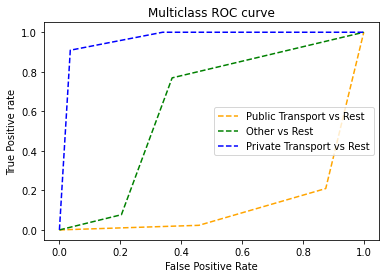

In [154]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Public Transport vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Other vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Private Transport vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

#### Feature Importance

<BarContainer object of 9 artists>

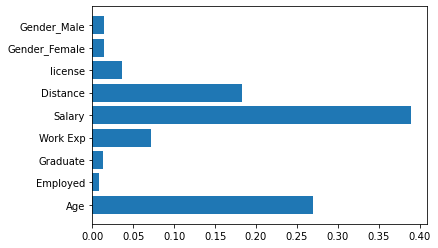

In [155]:
rf.feature_importances_
plt.barh(feature_list, rf.feature_importances_)

### Unsupervised Model - Regression Feature Selection

In [167]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(train_features)


KMeans(n_clusters=3)

In [168]:
train_pred = model.predict(train_features)
test_pred = model.predict(test_features)

In [169]:
orig = np.vectorize(reversefactor.get)(test_labels)
pred = np.vectorize(reversefactor.get)(test_pred)

In [170]:
print(pd.crosstab(orig, pred, rownames=['Actual'], colnames=['Predicted']))

Predicted          Other  Private Transport  Public Transport
Actual                                                       
Other                  1                  7                 5
Private Transport     10                  0                 1
Public Transport       2                 30                11


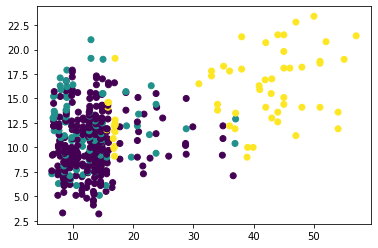

In [180]:
x_axis = features[:, 4]  # Salary
y_axis = features[:, 5]  # Distance

# Plotting
plt.scatter(x_axis, y_axis, c=labels)
plt.show()

#{'violet': 'Public Transport', 'green': 'Other', 'yellow': 'Private Transport'}